In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from numba import njit
from scipy.linalg import solve_triangular

In [2]:
# constants #

ki = 1.2e-06 # 1/s
kp = 500 # L/mol*s
ktc = 0.0 #6e06 # L/mol*s
ktd = 6e06 # L/mol*s
kfm = 9.1e-02 # L/mol*s
kfp = 0.5 # L/mol*s
kpp = 0.05 # L/mol*s
f = 1.0
M0 = 8.4 # mol/L
I0 = 0.002 #mol/L

In [3]:
@njit
def lambda_0(I): # moment zero for radicals
    return np.sqrt((2 * f * ki * I) / (ktd + ktc))

@njit
def lambda_1(M, L0, mu_1, mu_2): # momento one for radicals
    num = kp * M * L0 + kfp * L0 * mu_2
    denm = kfm * M + (ktd + ktc) * L0 + kfp * mu_1
    
    return num / denm

In [4]:
# Crear un array de 400 valores para n

n = np.arange(1, 401) * 2500  

# Crear un array con 400 elementos para b de propagación
b_p = 1.0 / np.diff(n)
b_p = np.append(b_p, b_p[-1])

In [5]:
# Función principal
def balances_KR(t, y):
    # Descomposición del vector de estados
    I = y[0]
    M = y[1]
    mu_0 = y[2]
    mu_1 = y[3]
    mu_2 = y[4]
    Npd = y[5:405]  # Polimeros

    # Cálculo de momentos de los radicales
    L0 = lambda_0(I)
    L1 = lambda_1(M, L0, mu_1, mu_2)

    # Ecuaciones diferenciales
    dIdt = -ki * I
    dMdt = -(kp + kfm) * M * L0
    dmu_0dt = kfm * M * L0 + (0.5 * ktc + ktd) * L0**2
    dmu_1dt = kp * M * L0
    dmu_2dt = kp * M * (L0 + 2 * L1) + ktc * L1**2

    # Ecuaciones para los polímeros
    dNpdt = np.zeros_like(Npd)

    # Resolver para los radicales con QSSA
    A = np.zeros((len(Npd), len(Npd)))
    b = np.zeros(len(Npd))

    for idx in range(len(Npd)):
        if idx == 0:
            A[idx, idx] = -(kfm * M + (ktd + ktc) * L0 + kfp * mu_1) - kp * M * b_p[idx]
            b[idx] = -(kfm * M * L0 + 2 * f * ki * I + kfp * L0 * n[idx] * Npd[idx])
        else:
            A[idx, idx] = -(kfm * M + (ktd + ktc) * L0 + kfp * mu_1) - kp * M * b_p[idx]
            A[idx, idx-1] = kp * M * b_p[idx-1]
            b[idx] = -(kfp * L0 * n[idx] * Npd[idx])
    
    Nrd = solve_triangular(A, b, lower=True)

    for idx in range(len(Npd)):
        dNpdt[idx] = (- kfp * L0 * n[idx] * Npd[idx]
                      + (kfm * M + ktd * L0 + kfp * mu_1) * Nrd[idx])

    # Concatenación de derivadas
    return np.concatenate(([dIdt, dMdt, dmu_0dt, dmu_1dt, dmu_2dt], dNpdt))

In [6]:
y0 = np.zeros(405)
y0[0] = I0
y0[1] = M0

time = [0, 35000]
t_get = [100, 1000, 3500, 10000, 15000, 40000, 60000, 71100, 90000]

In [7]:
sol = solve_ivp(
      balances_KR,
      time, 
      y0, 
      #t_eval=t_get,
      method='LSODA',
      rtol=1e-07,
      atol=1e-10)

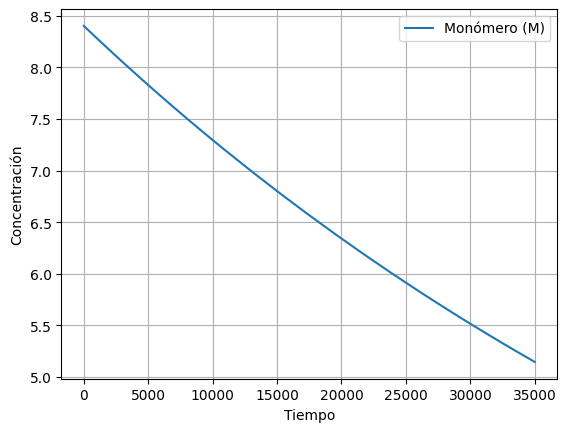

In [8]:
# Visualización
import matplotlib.pyplot as plt

#plt.plot(sol.t, sol.y[0], label="Iniciador (I)")
plt.plot(sol.t, sol.y[1], label="Monómero (M)")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Concentración")
plt.grid()
plt.show()

In [9]:
sol.y.shape

(405, 51)

8.399991911297935

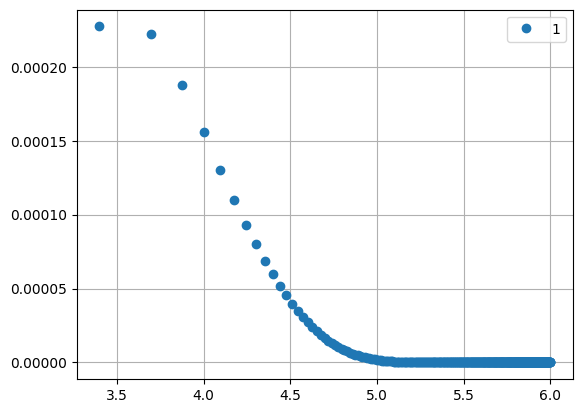

In [10]:
nlog = np.log10(n)
pn1 = sol.y[5:405, 40] / (1/b_p)

pn1n = np.multiply(pn1, n)

plt.plot(nlog, pn1n, 'o', label='1')
plt.grid()
plt.legend()

sol.y[1][7]

In [11]:
import numpy as np

def log_scale_integers(n, min_val, max_val):
    """
    Genera `n` valores enteros distribuidos logarítmicamente entre `min_val` y `max_val`, 
    reduciendo la densidad excesiva en valores altos.
    
    Parámetros:
        n (int): Cantidad de valores a generar.
        min_val (int): Valor mínimo.
        max_val (int): Valor máximo.
    
    Retorna:
        np.ndarray: Array de `n` valores enteros distribuidos logarítmicamente.
    """
    log_values = np.geomspace(min_val, max_val, n)  # Usa geomspace para mejor distribución
    int_values = np.unique(np.round(log_values).astype(int))
    
    # Asegurar que sean exactamente `n` valores únicos
    if len(int_values) < n:
        extra_values = np.linspace(min_val, max_val, n - len(int_values), dtype=int)
        int_values = np.unique(np.concatenate((int_values, extra_values)))
    
    return int_values # Asegurar que la longitud sea exactamente `n`

# Ejemplo de uso
n = log_scale_integers(400, 5, 1_000_000)

In [12]:
n = np.append(n, [1000200, 1030000])
n.shape

(400,)

In [13]:

# Crear un array con 400 elementos para b de propagación
b_p = 1.0 / np.diff(n)
b_p = np.append(b_p, b_p[-1])

In [14]:
y0 = np.zeros(405)
y0[0] = I0
y0[1] = M0

time = [0, 90000]
t_get = [100, 1000, 3500, 10000, 15000, 40000, 60000, 71100, 90000]

sol = solve_ivp(
      balances_KR,
      time, 
      y0, 
      t_eval=t_get,
      method='LSODA',
      rtol=1e-07,
      atol=1e-10
      )

3.1383347665713397

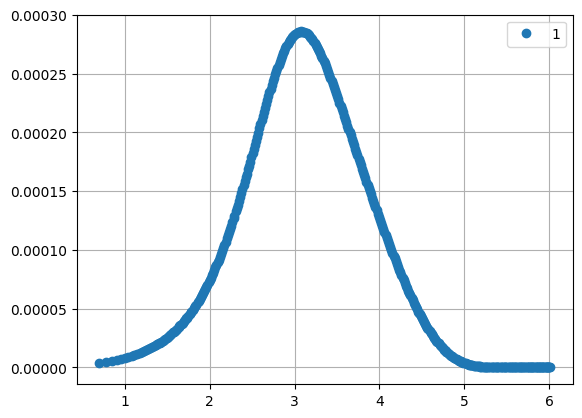

In [15]:
nlog = np.log10(n)
pn1 = sol.y[5:405, 6] / (1/b_p)

pn1n = np.multiply(pn1, n)
pn3n = np.multiply(pn1n, n)

plt.plot(nlog, pn1n, 'o', label='1')
#plt.plot(nlog, pn2, label='2')
#plt.plot(nlog, pn3, label='3')
plt.grid()
plt.legend()

sol.y[1][7]